In [ ]:
import pandas as pd

In [2]:
!pip install pyarrow

In [2]:
def preprocess_df(location):
    df = pd.read_parquet(location)
    df=df.head(50000)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration=df.duration.apply(lambda tr: tr.total_seconds()/60)
    df=df.drop(df[df.duration < 0].index)
    df=df[(df.duration >= 1) & (df.duration <= 60)]
    df.PULocationID = df.PULocationID.astype(str)
    df.DOLocationID = df.DOLocationID.astype(str)
    df['travel_map'] = df.PULocationID + "_" + df.DOLocationID

    return df


In [3]:
train_df = preprocess_df('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet')
val_df = preprocess_df('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet')

In [4]:
train_df.shape, val_df.shape

((48787, 22), (48997, 22))

In [5]:
# train_df['travel_map'] = train_df.PULocationID + "_" + train_df.DOLocationID
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,duration,travel_map
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,...,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0,8.350000,229_237
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,...,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,2.550000,236_237
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,...,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0,1.950000,141_141
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,...,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0,5.566667,244_244
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,...,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0,3.533333,244_116


In [6]:

# categories = ['PULocationID', 'DOLocationID']
categories = ['travel_map']
continuous = ['trip_distance']

In [7]:
X_train = train_df[categories+continuous].to_dict(orient='records')
X_val = val_df[categories+continuous].to_dict(orient='records')

In [8]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()

X_train = vectorizer.fit_transform(X_train)
y_train = train_df['duration'].values

X_val = vectorizer.transform(X_val)
y_val = val_df['duration'].values

In [10]:
vectorizer.feature_names_

['travel_map=100_1',
 'travel_map=100_100',
 'travel_map=100_107',
 'travel_map=100_113',
 'travel_map=100_114',
 'travel_map=100_116',
 'travel_map=100_12',
 'travel_map=100_125',
 'travel_map=100_129',
 'travel_map=100_13',
 'travel_map=100_132',
 'travel_map=100_134',
 'travel_map=100_137',
 'travel_map=100_138',
 'travel_map=100_140',
 'travel_map=100_141',
 'travel_map=100_142',
 'travel_map=100_143',
 'travel_map=100_144',
 'travel_map=100_145',
 'travel_map=100_146',
 'travel_map=100_147',
 'travel_map=100_148',
 'travel_map=100_150',
 'travel_map=100_151',
 'travel_map=100_158',
 'travel_map=100_161',
 'travel_map=100_162',
 'travel_map=100_163',
 'travel_map=100_164',
 'travel_map=100_166',
 'travel_map=100_167',
 'travel_map=100_169',
 'travel_map=100_170',
 'travel_map=100_181',
 'travel_map=100_186',
 'travel_map=100_188',
 'travel_map=100_189',
 'travel_map=100_193',
 'travel_map=100_198',
 'travel_map=100_200',
 'travel_map=100_209',
 'travel_map=100_211',
 'travel_map=10

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

model = LinearRegression()
# model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

LinearRegression()

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


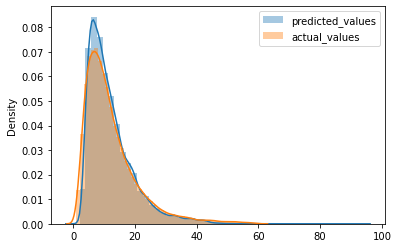

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)

sns.distplot(y_pred, label='predicted_values')
sns.distplot(y_val, label='actual_values')

plt.legend()



In [13]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_val, y_pred, squared=False)

4.62062744470233

In [14]:
import pickle

with open('models/lin_reg.bin', 'wb') as file:
    pickle.dump((vectorizer, model), file)